<img src="img/mvp_art.png" width=200 height=200 />

# CMSC320 Final Project Prototype
## Predicting the Most Valuable Player
---

In [1]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import selenium.webdriver as webdriver
import contextlib2
import unidecode as uni
sns.set(style="darkgrid")

## Finding MVP Candidates
---

In [2]:
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)),
                           level=i)
    return df
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: "".join(x))
    return df

In [3]:
votes = {}
for i in range(0,19):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(i+2001) + '.html')[0]
    data = rename_unnamed(data)
    data = collapse_columns(data)
    data = data.loc[:4, ['Rank', 'Player', 'Tm', 'VotingShare']]
    votes[i+2001] = data

## MVP Candidate Database Builder
---

    # subprocess.call(['rm','-rf','MVP'])
    # subprocess.call(['mkdir','MVP'])
    for year in votes:
        for name in votes[year]['Player']:
            if not (os.path.isdir('MVP/' + str(year) + '/' + name)):
                if not name in (['Isaiah Thomas', 'Anthony Davis']):
                    link = str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '01'
                else:
                    link = str.lower(name.split()[1])[:1] + '/' + \
                            uni.unidecode(str.lower(name.split()[1]).replace("'", ""))[:5] + \
                                str.lower(name.split()[0]).replace("'", "")[:2] + '02'

                @contextlib2.contextmanager
                def quitting(thing):
                    yield thing
                    thing.quit()
                with quitting(webdriver.Firefox()) as driver:
                    link = 'https://www.basketball-reference.com/players/' + link + '.html' 
                    driver.get(link)
                    content = driver.page_source
                    with open('/tmp/out.html', 'wb') as f:
                        f.write(content.encode('utf-8'))
                    data = pd.read_html(content)

                path1 = 'MVP/' + str(year)
                path2 = 'MVP/' + str(year) + '/' + name
                subprocess.call(['mkdir', path1])
                subprocess.call(['mkdir', path2])

                pergame = data[18]
                pergame.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
                if pergame['3P%'].isnull().any():
                    pergame.drop(columns='3P%',inplace=True)
                pergame.dropna(inplace=True)
                pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
                pergame['Age'] = pergame['Age'].astype(int)
                pergame['G'] = pergame['G'].astype(int)
                pergame['GS'] =pergame['GS'].astype(int)
                pergame = pergame[pergame['Season'] == year]
                pergame.reset_index(inplace=True,drop=True)
                pergame = pergame.loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                                        'FG%', '3P%', 'eFG%', 'FT%']]
                # pergame.to_csv(path2 + '/Table_PerGame.csv')
                pergame.to_csv(path2 + '/PerGame.csv')

                advanced = data[22]
                if 'Unnamed: 19' in advanced.columns:
                    advanced.drop(columns=['Unnamed: 19', 'Unnamed: 24'],inplace=True)
                advanced.replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
                advanced.dropna(inplace=True)
                advanced['Season'] = [int(str(x).split('-')[0])+1 for x in advanced['Season']]
                advanced['Age'] = advanced['Age'].astype(int)
                advanced['G'] = advanced['G'].astype(int)
                advanced = advanced[advanced['Season'] == year]
                advanced.reset_index(inplace=True,drop=True)
                advanced = advanced.loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'TRB%', 
                                            'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 
                                            'OBPM', 'DBPM', 'BPM', 'VORP']]
                # advanced.to_csv(path2 + '/Table_Advanced.csv')
                advanced.to_csv(path2 + '/Advanced.csv')
        i = 0
        for team in votes[year]['Tm']:
            if team == 'NOP':
                team = 'NOH'
            name = votes[year]['Player'][i]
    #         if not (os.path.isfile('MVP/' + str(year) + '/' + name + '/Team.csv')):
            table = pd.read_html('https://www.basketball-reference.com/teams/' + team + 
                                 '/stats_per_game_totals.html')[0]
            table.replace('Season', '0000-00', inplace=True)
            table['Season'] = [int(str(x).split('-')[0])+1 for x in table['Season']]
            table = table[table['Season'] == year]
            table['Win_Pct'] = table['W'].astype(int)/table['G'].astype(int)
            table = table.loc[:, ['Season', 'Tm', 'W', 'L', 'Win_Pct', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                                  'FG%', '3P%', 'FT%']]
            table.to_csv('MVP/' + str(year) + '/' + name + '/Team.csv')
            i += 1

In [4]:
per_game = {}
advanced = {}
team_data = {}
for year in votes:
    i = 0
    for name in votes[year]['Player']:
        path = 'MVP/' + str(year) + '/' + name
        per_game[(name,year)] = pd.read_csv(path + '/' + 'Table_PerGame.csv').drop(columns='Unnamed: 0')
        per_game[(name,year)]['Name'] = name
        per_game[(name,year)]['VotingShare'] = votes[year]['VotingShare'][i]
        advanced[(name,year)] = pd.read_csv(path + '/' + 'Table_Advanced.csv').drop(columns='Unnamed: 0')
        advanced[(name,year)]['Name'] = name
        advanced[(name,year)]['VotingShare'] = votes[year]['VotingShare'][i]
        i += 1
    i = 0
    for team in votes[year]['Tm']:
        name = votes[year]['Player'][i]
        team_data[(name,year)] = pd.read_csv('MVP/' + str(year) + '/' + name + 
                                             '/Team.csv').drop(columns='Unnamed: 0')
        team_data[(name,year)]['Name'] = name
        team_data[(name,year)]['VotingShare'] = votes[year]['VotingShare'][i]
        i += 1

In [5]:
pg = pd.DataFrame()
for year in votes:
    for name in votes[year]['Player']:
        pg = pg.append(per_game[(name,year)], ignore_index=True)
adv = pd.DataFrame()
for year in votes:
    for name in votes[year]['Player']:
        adv = adv.append(advanced[(name,year)], ignore_index=True)
tm = pd.DataFrame()
for year in votes:
    for name in votes[year]['Player']:
        tm = tm.append(team_data[(name,year)], ignore_index=True)

In [6]:
pg

,Season,Tm,Pos,G,MP,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,eFG%,FT%,Name,VotingShare
0,2001,PHI,SG,71,42.0,31.1,3.8,4.6,2.5,0.3,3.3,0.420,0.320,0.447,0.814,Allen Iverson,0.904
1,2001,SAS,PF,82,38.7,22.2,12.2,3.0,0.9,2.3,3.0,0.499,0.259,0.502,0.618,Tim Duncan,0.569
2,2001,LAL,C,74,39.5,28.7,12.7,3.7,0.6,2.8,2.9,0.572,NaN,0.572,0.513,Shaquille O'Neal,0.466
3,2001,SAC,PF,70,40.5,27.1,11.1,4.2,1.3,1.7,2.8,0.481,0.071,0.481,0.703,Chris Webber,0.420
4,2001,MIN,PF,81,39.5,22.0,11.4,5.0,1.4,1.8,2.8,0.477,0.288,0.484,0.764,Kevin Garnett,0.122
5,2002,SAS,PF,82,40.6,25.5,12.7,3.7,0.7,2.5,3.2,0.508,0.100,0.508,0.799,Tim Duncan,0.757
6,2002,NJN,PG,82,37.3,14.7,7.3,9.9,2.1,0.2,3.5,0.391,0.321,0.442,0.814,Jason Kidd,0.712
7,2002,LAL,C,67,36.1,27.2,10.7,3.0,0.6,2.0,2.6,0.579,NaN,0.579,0.555,Shaquille O'Neal,0.552
8,2002,ORL,SG,76,38.3,25.6,7.9,5.3,1.6,1.0,2.5,0.451,0.364,0.483,0.748,Tracy McGrady,0.310
9,2002,LAL,SG,80,38.3,25.2,5.5,5.5,1.5,0.4,2.8,0.469,0.250,0.479,0.829,Kobe Bryant,0.078


In [8]:
adv

,Season,Tm,Pos,G,MP,PER,TS%,3PAr,FTr,TRB%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Name,VotingShare
0,2001,PHI,SG,71,2979.0,24.0,0.518,0.169,0.397,5.2,...,7.3,4.5,11.8,0.190,5.0,-0.1,4.8,5.1,Allen Iverson,0.904
1,2001,SAS,PF,82,3174.0,23.8,0.536,0.019,0.471,17.8,...,6.2,7.1,13.2,0.200,1.8,3.6,5.4,5.9,Tim Duncan,0.569
2,2001,LAL,C,74,2924.0,30.2,0.574,0.001,0.684,18.1,...,11.1,3.9,14.9,0.245,5.7,1.6,7.3,6.8,Shaquille O'Neal,0.466
3,2001,SAC,PF,70,2836.0,24.7,0.516,0.017,0.282,14.8,...,5.8,5.2,11.0,0.186,2.6,2.4,4.9,4.9,Chris Webber,0.420
4,2001,MIN,PF,81,3202.0,23.9,0.531,0.045,0.317,16.4,...,7.0,4.8,11.8,0.176,3.0,2.7,5.7,6.2,Kevin Garnett,0.122
5,2002,SAS,PF,82,3329.0,27.0,0.576,0.007,0.466,18.0,...,10.7,7.1,17.8,0.257,3.9,3.8,7.6,8.1,Tim Duncan,0.757
6,2002,NJN,PG,82,3056.0,19.1,0.484,0.320,0.217,10.9,...,3.1,5.8,8.9,0.140,2.8,2.2,5.1,5.4,Jason Kidd,0.712
7,2002,LAL,C,67,2422.0,29.7,0.590,0.001,0.583,16.3,...,9.2,4.0,13.2,0.262,5.5,1.5,7.0,5.5,Shaquille O'Neal,0.552
8,2002,ORL,SG,76,2912.0,25.1,0.532,0.178,0.350,11.5,...,8.1,3.4,11.5,0.189,5.2,0.8,6.0,5.9,Tracy McGrady,0.310
9,2002,LAL,SG,80,3063.0,23.2,0.544,0.083,0.369,7.9,...,8.9,3.8,12.7,0.199,4.4,0.1,4.4,5.0,Kobe Bryant,0.078


In [9]:
tm

,Season,Tm,W,L,Win_Pct,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare
0,2001,PHI,56,26,0.682927,94.7,44.8,20.6,8.4,5.0,15.8,0.447,0.326,0.745,Allen Iverson,0.904
1,2001,SAS,58,24,0.707317,96.2,44.1,21.7,6.9,7.0,14.0,0.461,0.407,0.715,Tim Duncan,0.569
2,2001,LAL,56,26,0.682927,100.6,44.7,23.0,6.9,6.0,14.4,0.465,0.344,0.683,Shaquille O'Neal,0.466
3,2001,SAC,55,27,0.670732,101.7,45.0,22.6,9.7,5.3,14.9,0.449,0.354,0.771,Chris Webber,0.420
4,2001,MIN,47,35,0.573171,97.3,42.3,25.4,8.3,5.6,13.9,0.458,0.357,0.785,Kevin Garnett,0.122
5,2002,SAS,58,24,0.707317,96.7,42.4,20.0,7.6,6.5,14.4,0.458,0.362,0.742,Tim Duncan,0.757
6,2002,NJN,52,30,0.634146,96.2,43.3,24.3,8.7,6.0,14.5,0.446,0.338,0.735,Jason Kidd,0.712
7,2002,LAL,58,24,0.707317,101.3,44.3,23.0,7.6,5.8,12.7,0.461,0.354,0.699,Shaquille O'Neal,0.552
8,2002,ORL,44,38,0.536585,100.5,41.2,22.0,8.1,4.7,13.6,0.448,0.373,0.754,Tracy McGrady,0.310
9,2002,LAL,58,24,0.707317,101.3,44.3,23.0,7.6,5.8,12.7,0.461,0.354,0.699,Kobe Bryant,0.078


### Brief Descriptive Statistics (EDA)

/Users/rreddy/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


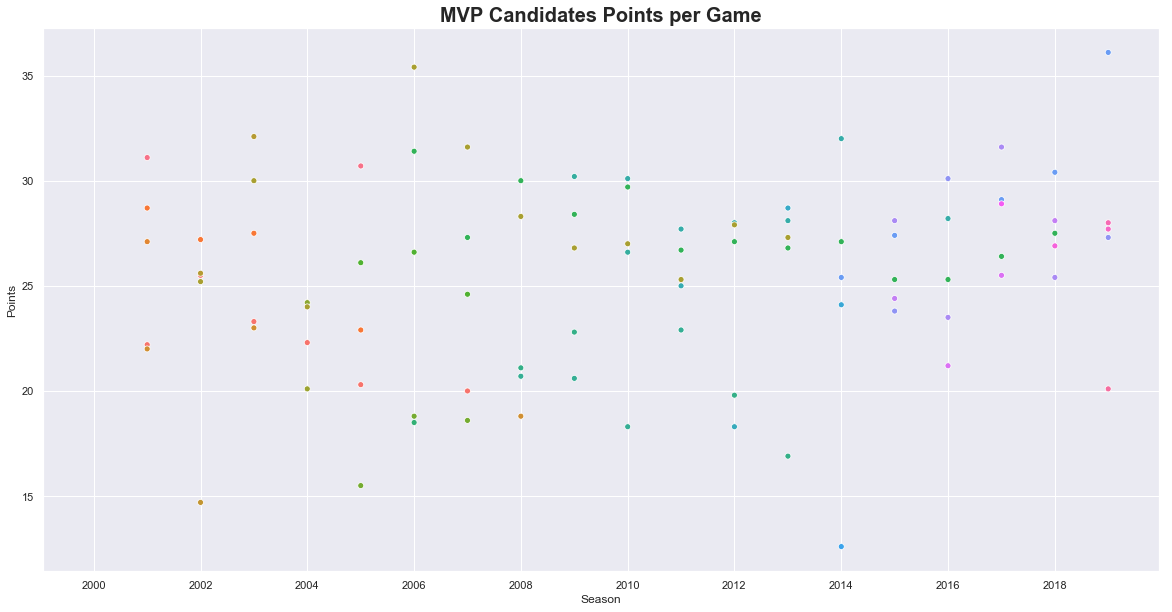

In [10]:
pts = pg.loc[:, ['Name', 'Season', 'PTS']]
pts['Season'] = [pd.to_datetime(x, format='%Y') for x in pts['Season']]

plt.figure(figsize=(20,10))
p = sns.scatterplot(x='Season',y='PTS',hue='Name',data=pts,legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Candidates Points per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Points')
plt.show()

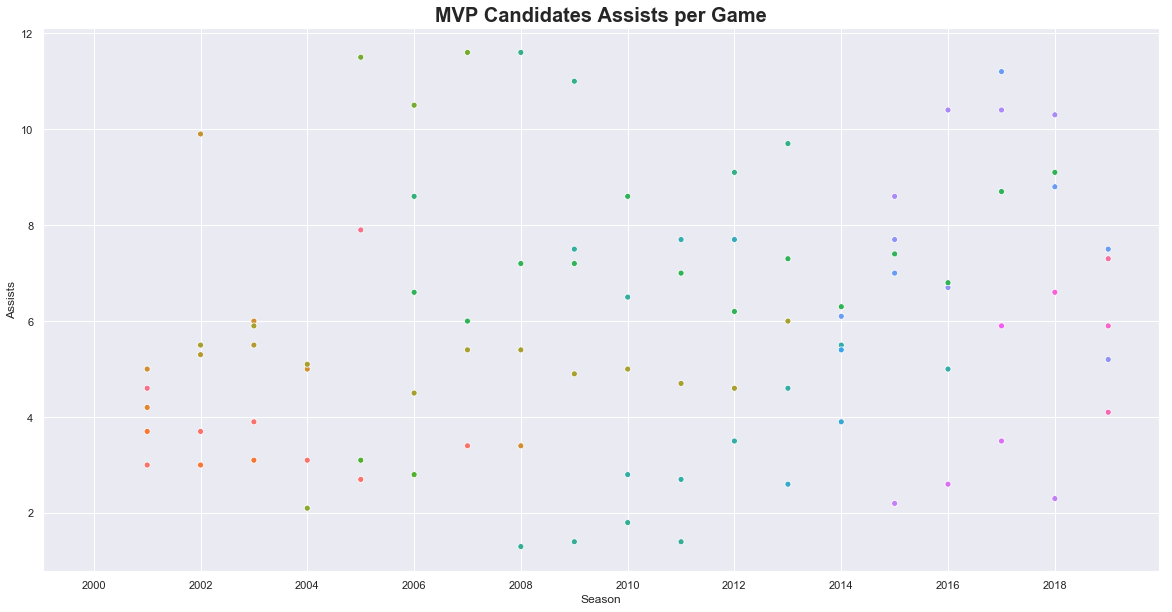

In [11]:
ast = pg.loc[:, ['Name', 'Season', 'AST']]
ast['Season'] = [pd.to_datetime(x, format='%Y') for x in ast['Season']]

plt.figure(figsize=(20,10))
p = sns.scatterplot(x='Season',y='AST',hue='Name',data=ast,legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Candidates Assists per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Assists')
plt.show()

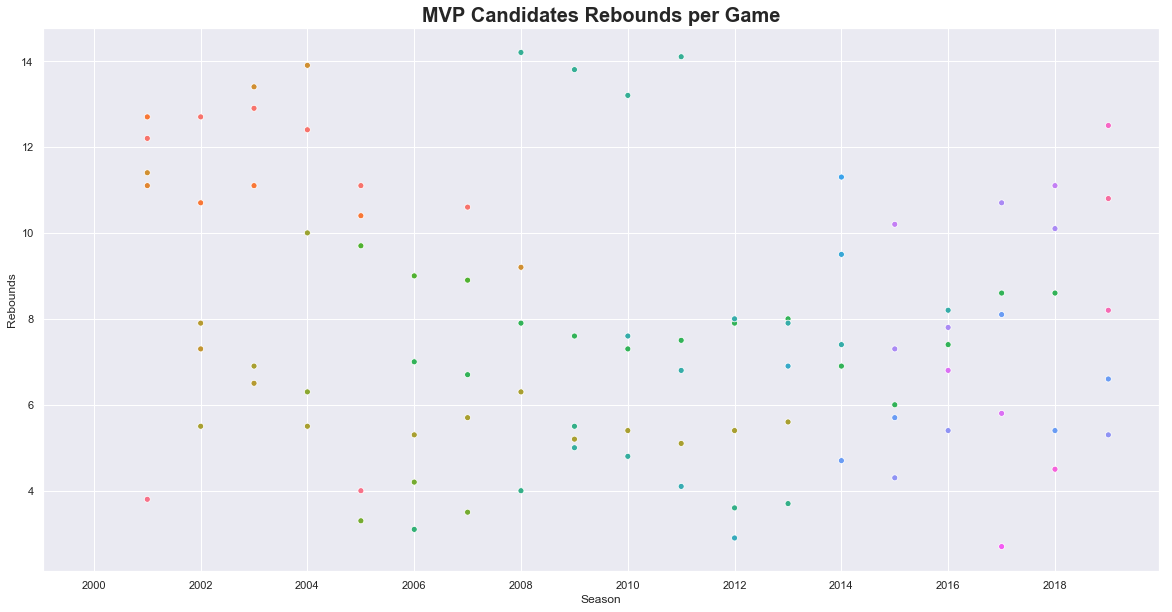

In [12]:
reb = pg.loc[:, ['Name', 'Season', 'TRB']]
reb['Season'] = [pd.to_datetime(x, format='%Y') for x in reb['Season']]

plt.figure(figsize=(20,10))
p = sns.scatterplot(x='Season',y='TRB',hue='Name',data=reb,legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Candidates Rebounds per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Rebounds')
plt.show()

To mark which players won the MVP award each time, we add a column labeled "MVP" to each of the three tables. If the MVP column for a certain row is 1, then the player won the MVP award that year. Otherwise, a zero represents that the player did not win the MVP award that year.

In [14]:
pg['MVP'] = np.nan

for index, row in pg.iterrows():
    if index % 5 == 0:
        pg['MVP'][index] = 1.0
    else:
        pg['MVP'][index] = 0

/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [15]:
tm['MVP'] = np.nan

for index, row in tm.iterrows():
    if index % 5 == 0:
        tm['MVP'][index] = 1.0
    else:
        tm['MVP'][index] = 0

/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [19]:
adv['MVP'] = np.nan

for index, row in pg.iterrows():
    if index % 5 == 0:
        adv['MVP'][index] = 1.0
    else:
        adv['MVP'][index] = 0

/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [16]:
tm.head()

,Season,Tm,W,L,Win_Pct,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,MVP
0,2001,PHI,56,26,0.682927,94.7,44.8,20.6,8.4,5.0,15.8,0.447,0.326,0.745,Allen Iverson,0.904,1.0
1,2001,SAS,58,24,0.707317,96.2,44.1,21.7,6.9,7.0,14.0,0.461,0.407,0.715,Tim Duncan,0.569,0.0
2,2001,LAL,56,26,0.682927,100.6,44.7,23.0,6.9,6.0,14.4,0.465,0.344,0.683,Shaquille O'Neal,0.466,0.0
3,2001,SAC,55,27,0.670732,101.7,45.0,22.6,9.7,5.3,14.9,0.449,0.354,0.771,Chris Webber,0.420,0.0
4,2001,MIN,47,35,0.573171,97.3,42.3,25.4,8.3,5.6,13.9,0.458,0.357,0.785,Kevin Garnett,0.122,0.0


In [25]:
revised_dataset = adv[adv['MVP'] == 1]

pos_map = {'C': 0, 'PF': 0, 'SF': 0, 'SG': 0, 'PG': 0}

for index, row in revised_dataset.iterrows():
    pos_map[revised_dataset['Pos'][index]] += 1

/Users/rreddy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [26]:
pos_map

{'C': 1, 'PF': 6, 'SF': 4, 'SG': 4, 'PG': 4}

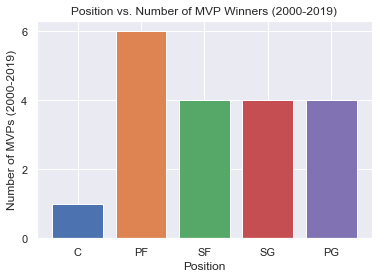

In [29]:
for key in pos_map:
    plt.bar(key, pos_map[key])

plt.title("Position vs. Number of MVP Winners (2000-2019)")
plt.xlabel("Position")
plt.ylabel("Number of MVPs (2000-2019)")
plt.yticks(np.arange(0, 8, step = 2))
plt.show()

In the last twenty years, the MVP winners appear to play a variety of positions with the exception of Center (C) position. Of the last twenty winners, six played as Power Fowards (PF), four winners played as Small Forwards (SF), four winners played as Shooting Guards (SG), and four winners played as Point Guards (PG). 

There was only one player in the last twenty years that won the MVP award as a Center (Dwight Howard, 2011). Reasonably speaking, this is likely because Center players tend to be more defensive than high-scoring offensive players. As we will see, a key predictor in determining MVP winners is focusing on how many points they score.

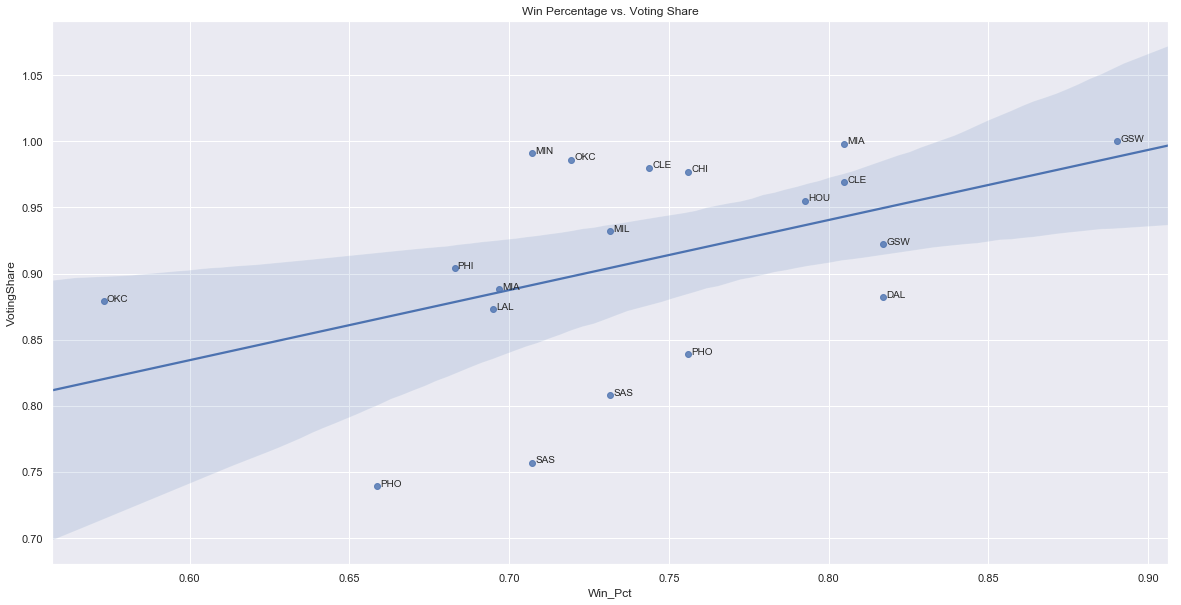

In [30]:
plt.figure(figsize = (20,10))

revised_tm = tm[tm['MVP'] == 1.0]
ax = sns.regplot(x = "Win_Pct", y = "VotingShare", data = revised_tm, label = "test").set_title("Win Percentage vs. Voting Share")

for index, row in revised_tm.iterrows():
    plt.annotate("".join(revised_tm['Tm'][index]), xy = (revised_tm['Win_Pct'][index] + 0.001, revised_tm['VotingShare'][index]))

As shown above, the voting share for the winning candidate had a fair amount of dependency on their team's win percentage. In other words, the higher the win percentage of a team, the higher the voting share for a certain player of that team tended to be.

In [17]:
revised_tm.head()

,Season,Tm,W,L,Win_Pct,PTS,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,MVP
0,2001,PHI,56,26,0.682927,94.7,44.8,20.6,8.4,5.0,15.8,0.447,0.326,0.745,Allen Iverson,0.904,1.0
5,2002,SAS,58,24,0.707317,96.7,42.4,20.0,7.6,6.5,14.4,0.458,0.362,0.742,Tim Duncan,0.757,1.0
10,2003,SAS,60,22,0.731707,95.8,42.6,20.0,7.7,6.5,15.8,0.462,0.354,0.725,Tim Duncan,0.808,1.0
15,2004,MIN,58,24,0.707317,94.5,42.9,23.0,6.8,5.6,12.7,0.462,0.363,0.781,Kevin Garnett,0.991,1.0
20,2005,PHO,62,20,0.756098,110.4,44.1,23.5,7.0,5.5,13.7,0.477,0.393,0.748,Steve Nash,0.839,1.0
